In [ ]:
import pandas as pd
import numpy as np
from all_funcs import mod_df


## Merging dataset

In [ ]:
mod_df(66)

In [ ]:
def merge_dfs(dfs):
  df = pd.concat(dfs)
  df = pd.get_dummies(df)
  df = df.sort_values(by = 'Дата')
  return df

In [ ]:
def add_factor(df, name):
  new_df = pd.read_excel(name)
  new_df['Дата'] = pd.to_datetime(new_df['Дата'])
  new_df = new_df.resample('D', on='Дата').median().ffill()
  return df.merge(new_df, left_on = df.index, right_on = new_df.index)

In [ ]:
dfs = []
for name in ['альфа-банк.xlsx', 'банк-втб.xlsx' , 'сбербанк-россии.xlsx', 'газпром-капитал.xlsx', 'газпром-нефть.xlsx', 'гсп-финанс.xlsx', 'россия,-29006.xlsx', 'россия,-29007.xlsx', 'россия,-29013.xlsx']:
  dfs.append(mod_df(name))

<ipython-input-86-755bc82303f2>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('D', on='Дата').median().ffill()
<ipython-input-86-755bc82303f2>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('D', on='Дата').median().ffill()
<ipython-input-86-755bc82303f2>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('D', on='Дата').median().ffill()
<ipython-input-86-755b

In [ ]:
for i in range(len(dfs)):
  for name in ['rub-yield-curve-10y (1).xlsx', 'rucbcp3a3yns.xlsx', 'usd_rub-(fx) (1).xlsx', 'ставка-ruonia.xlsx']:
    dfs[i] = add_factor(dfs[i], name)
    dfs[i]['key_0'] = pd.to_datetime(dfs[i]['key_0'])
    dfs[i] = dfs[i].set_index('key_0')

In [ ]:
dfs[1].head(3)

,Indicative,YTM Indicative,G-spread,t,ISIN,name,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,,,
2022-01-05,99.145,0.2288,-804.340413,1,RU000A102EJ3,банк-втб.xlsx,8.3386,100.80,76.11534,8.13
2022-01-06,98.675,0.3504,-815.156042,2,RU000A102EJ3,банк-втб.xlsx,8.4660,100.56,76.43210,8.13
2022-01-07,98.675,0.3504,-815.156042,3,RU000A102EJ3,банк-втб.xlsx,8.4660,100.56,75.27871,8.13


### Analysis function

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import math
import scipy.stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import t
from scipy.stats import f
from scipy.stats import kurtosis, skew

In [ ]:
def graphs(data):
  data.plot()
  plt.show()
  sns.displot(data, kind = 'kde')
  plt.show()
  sns.boxplot(data)
  plt.show()

In [ ]:
def student_test (y1, y2, n1, n2, var1, var2, a):
  if (var1 != var2):
    St = ((y1-y2)/math.sqrt(var1/(n1-1)+var2/(n2-1)))
  else:
    St = ((y1-y2)/var1 * math.sqrt(((n1)*(n2))/(n1+n2)))
  return St

In [ ]:
def _get_updown_sub_serias(series):
    subseries = [None, ]
    for i in range(len(series)):
        if i == 1:
            pass
        else:
            if (series[i] - series[i-1]) > 0:
                subseries.append('+')
            else:
                subseries.append('-')
    return subseries

def _get_numeric_updown_criteria(subseries):
    number_subseries = 0
    numeric_subseries = [None, ]
    for i in range(len(subseries)):
        if i == 1:
            pass
        else:
            if subseries[i] != subseries[i-1]:
                number_subseries += 1
                numeric_subseries.append(number_subseries)
            else:
                numeric_subseries.append(number_subseries)
                
    return numeric_subseries
    

def updown_criteria(series):
    subseries = _get_updown_sub_serias(series)
    numeric_subseries = _get_numeric_updown_criteria(subseries)
    sub_df = pd.DataFrame({'series': series, 'subseries': subseries, 'numeric_subs': numeric_subseries})
    val_count_sub_df = sub_df['numeric_subs'].value_counts()
    total_subdf = pd.merge(sub_df, val_count_sub_df, how='left', left_on='numeric_subs', right_index=True)
    
    v_n = total_subdf['numeric_subs_x'].max()
    t_n = total_subdf['numeric_subs_y'].max()
    
    u_t = 1.96
    
    n = total_subdf.shape[0]-1
    
    criteria_x = 1/3 * (2*n-1) - u_t* np.sqrt((16*n-29)/90)
    
    if n <= 26:
        criteria_y = 5
    elif n>26 and n <= 153:
        criteria_y = 6
    elif n>153 and n <= 1170:
        criteria_y = 7
    else:
        criteria_y = 8    
    
    print(f'Число серий v_n = {v_n} больше критического значения равного {criteria_x}: {v_n > criteria_x}')
    print(f'Длина максимальной серии t_n = {t_n} меньше критического значения равного {criteria_y}: {t_n < criteria_y}')
    print('При нарушении хотя бы одного из условий ряд нестационарный')

In [ ]:
from scipy.stats import mannwhitneyu
def test_mannwhitneyu(series):
    stat, p = mannwhitneyu(series[:int(len(series)/2)], series[int(len(series)/2):])
    print('stat={0:.3g}, p={0:.3g}'.format(stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

In [ ]:
def _get_ranked(series):
    series_max_index = len(series)
    first_sublist = list(range(2,series_max_index,4))
    first_sublist = sorted(first_sublist + list(range(min(first_sublist)+1, max(first_sublist)+2, 4)))
    second_sublist = [col for col in list(range(1,series_max_index+1)) if col not in first_sublist]
    first_sublist.reverse()
    return second_sublist + first_sublist  

def siegel_tukey(series):
    first_subsample, second_subsample = series[:int(len(series)/2)], series[int(len(series)/2):]
    first_subsample, second_subsample = pd.DataFrame({'values': first_subsample}), pd.DataFrame({'values': second_subsample})
    first_subsample['class'] = 'first'
    second_subsample['class'] = 'second'
    final_df = pd.concat([first_subsample,second_subsample]).sort_values(by='values')
    
    final_df['ranked'] = _get_ranked(final_df['values'])
    _ = pd.pivot_table(final_df, index='class', aggfunc=['sum'])['sum']['ranked']
    mean_w = _['first']-len(first_subsample)*(len(first_subsample)+len(second_subsample)+1)/2 
    disp_w = len(first_subsample)*len(second_subsample)*(len(first_subsample)+len(second_subsample)+1)/12
    if disp_w != 0:
        z_value = mean_w/np.sqrt(disp_w)
    else:
        print(f'disp_w = 0')
        
    if z_value < 0:
        z_value = (mean_w + 0.5) / np.sqrt(disp_w)
    else:
        z_value = (mean_w - 0.5) / np.sqrt(disp_w)
    print(f'z value: {z_value:.3f}')
    if z_value < 1.97 and z_value > -1.97:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

In [ ]:
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import norm
from statsmodels.iolib.table import SimpleTable
def test_normal_dist(series):
    print('================')
    print('Тест Jarque Bera')
    row =  [u'JB', u'p-value', u'skew', u'kurtosis']
    jb_test = sm.stats.stattools.jarque_bera(series)
    a = np.vstack([jb_test])
    itog = SimpleTable(a, row)
    print(itog)
    alpha = 0.05
    # if itog['p-value'] > alpha:
    #     print('Принять гипотезу о нормальности')
    # else:
    #     print('Отклонить гипотезу о нормальности')       
    print('')
    print('================')
    print('Тест Шапиро-Уилк')
    stat, p = shapiro(series) # тест Шапиро-Уилк 
    print('Statistics=%.3f, p-value=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('Отклонить гипотезу о нормальности')        
            
def get_distribution(series):
    print(test_normal_dist(series))
    
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(4, 1)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[2, 0])
    ax3 = fig.add_subplot(gs[3, 0])
    sns.kdeplot(norm(loc=series.mean(), scale=np.std(series)).rvs(size=700), ax=ax0, color='#b3e8c9', fill=True, alpha=1)
    sns.kdeplot(ax=ax0, x=series)     
    sns.histplot(ax=ax1, x=series, fill=False)     
    sns.boxplot(series, ax=ax2)
    sm.qqplot(series, ax=ax3, line="s")

In [ ]:
def kurt_skew(data):
  print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(data) ))
  print( 'skewness of normal distribution (should be 0): {}'.format( skew(data) ))

In [ ]:
def cap_outliers(data, i, j): 
  data = data.sort_values()
  if i!=0:
    data.iloc[0:i] = data.iloc[i]
  if j!=0:
    data.iloc[(len(data)-j):len(data)] = data.iloc[len(data) - j]
  data = data.sort_index()
  return(data)

In [ ]:
def t_f_criterion(data):
  X = data.values
  split = round(len(X) / 2)
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()
  var1, var2 = X1.var(), X2.var()
  print('Тестирование средних. Статистика Стьюдента: {}. Критическое значение: {}'.format(((mean1-mean2)/math.sqrt(var1+var2)), t.ppf(0.95, len(X1)-1)))
  print('Тестирование дисперсий. Статистика Фишера: {}. Критическое значение: {}'.format(var2/var1, f.ppf(0.95, len(X1)-1, len(X2)-1)))

In [ ]:
import statistics
def median_criterion (data):
  result = []
  for i in range(len(data)):
    if data[i] < statistics.median(data):
      result.append('-')
    elif data[i] == statistics.median(data): result.append(' ')
    else: result.append('+')
  vt = 1
  tmax = 1
  t = 1
  for i in range(1, len(result)):
    if result[i] == result[i-1]: 
      vt = vt
      t += 1
      if t > tmax: tmax = t
    else:  
      vt +=1
      t = 0
  print('Число серий = {} больше рассчитанного {}: {}'.format(vt, (0.5*(len(data) + 2) - 1.96*math.sqrt(len(data)-1)), vt > (0.5*(len(data) + 2) - 1.96*math.sqrt(len(data)-1))))
  print('Максимальная длина серии = {} меньше рассчитанного {}: {}'.format(tmax, (1.43 * math.log(len(data + 1))), tmax < (1.43 * math.log(len(data + 1)))))
  print('При нарушении хоть одного условия, ряд не стационарный')
  print(statistics.median(data))
  print(result)


In [ ]:
def make_autocorr_plot(series, lags=24):
    background_color = '#f6f5f5'
    fig = plt.figure(figsize=(10, 8), facecolor=background_color)
    gs = fig.add_gridspec(2, 1)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])

    # ax0.set_facecolor(background_color)
    # ax1.set_facecolor(background_color)
    
    
    # background_color = '#f6f5f5'
    # ax0.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
    # ax0.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
    # ax0.axes.xaxis.set_visible(False)
    # ax1.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
    # ax1.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
    
    plot_acf(series, lags=lags, zero=False, ax=ax0);
    plot_pacf(series, lags=lags, zero=False, ax=ax1);

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [ ]:
def get_corr(data):
  sns.heatmap(data.select_dtypes(include=numerics).corr(), vmin = -1, annot = True, vmax = 1)
  plt.show()

In [ ]:
def boxplots(df):
  for column in df.select_dtypes(include=numerics):
        plt.figure(figsize=(10,1))
        sns.boxplot(data=df, x=column)

In [ ]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [ ]:
def ult_analysis(data):
  print(data.info())
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 1')
  print(data.isna().sum())
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 2')
  print(data.duplicated().sum())
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 3')
  get_corr(data)
  plt.show()
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 4')
  print(find_outliers_IQR(data['Indicative']))
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 5')
  boxplots(data)
  plt.show()
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 6')
  graphs(data[['Indicative']])
  plt.show()
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 7')
  test_normal_dist(data['Indicative'])
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 8')
  get_distribution(data['Indicative'])
  plt.show()
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 9')
  make_autocorr_plot(data['Indicative'])
  plt.show()
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 10')
  t_f_criterion(data['Indicative'])
  print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 11')
  kurt_skew(data['Indicative'])

## Banking

In [ ]:
dfs[0].head()

,Indicative,YTM Indicative,G-spread,t,ISIN,name,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,,,
2022-01-03,96.550,8.1217,-6.763896,1,RU000A102A07,альфа-банк.xlsx,8.3678,100.51,74.58064,8.13
2022-01-04,96.235,8.3266,13.549479,2,RU000A102A07,альфа-банк.xlsx,8.3704,100.72,75.16675,8.13
2022-01-05,95.690,8.6823,50.324341,3,RU000A102A07,альфа-банк.xlsx,8.3386,100.80,76.11534,8.13
2022-01-06,95.505,8.8061,36.877612,4,RU000A102A07,альфа-банк.xlsx,8.4660,100.56,76.43210,8.13
2022-01-07,95.505,8.8061,36.877612,5,RU000A102A07,альфа-банк.xlsx,8.4660,100.56,75.27871,8.13


In [2]:
def three_graphs_one_plot (df1, df2, df3):
  fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')
  ax.plot(df1['Indicative'], label=df1['name'][0])  
  ax.plot(df2['Indicative'], label=df2['name'][0])  
  ax.plot(df3['Indicative'], label=df3['name'][0])  
  ax.legend()

In [ ]:
three_graphs_one_plot(dfs[0], dfs[3], dfs[6])

In [ ]:
df_alph = dfs[0][dfs[0].index >= '2022-05-01']

In [ ]:
df_alph['Indicative'] = np.log(df_alph['Indicative'])

In [ ]:
def fac_plots(df):
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
  ll = ['YTM Indicative', 'G-spread', 'RUB Yield Curve 10Y', 'RUCBCP3A3YNS', 'USD/RUB (FX)', 'Ставка RUONIA']
  for i in range(len(ll)):
    if i > 2: 
      j = 1 
    else: j = 0
    ax[j, i%3].plot(df[ll[i]], label=ll[i])
    ax[j, i%3].legend()
  # for name in ['YTM Indicative', 'G-spread', 'RUB Yield Curve 10Y', 'RUCBCP3A3YNS', 'USD/RUB (FX)', 'Ставка RUONIA']:
  #   dfs[0][name].plot()
  #   plt.show()
  fig.tight_layout()

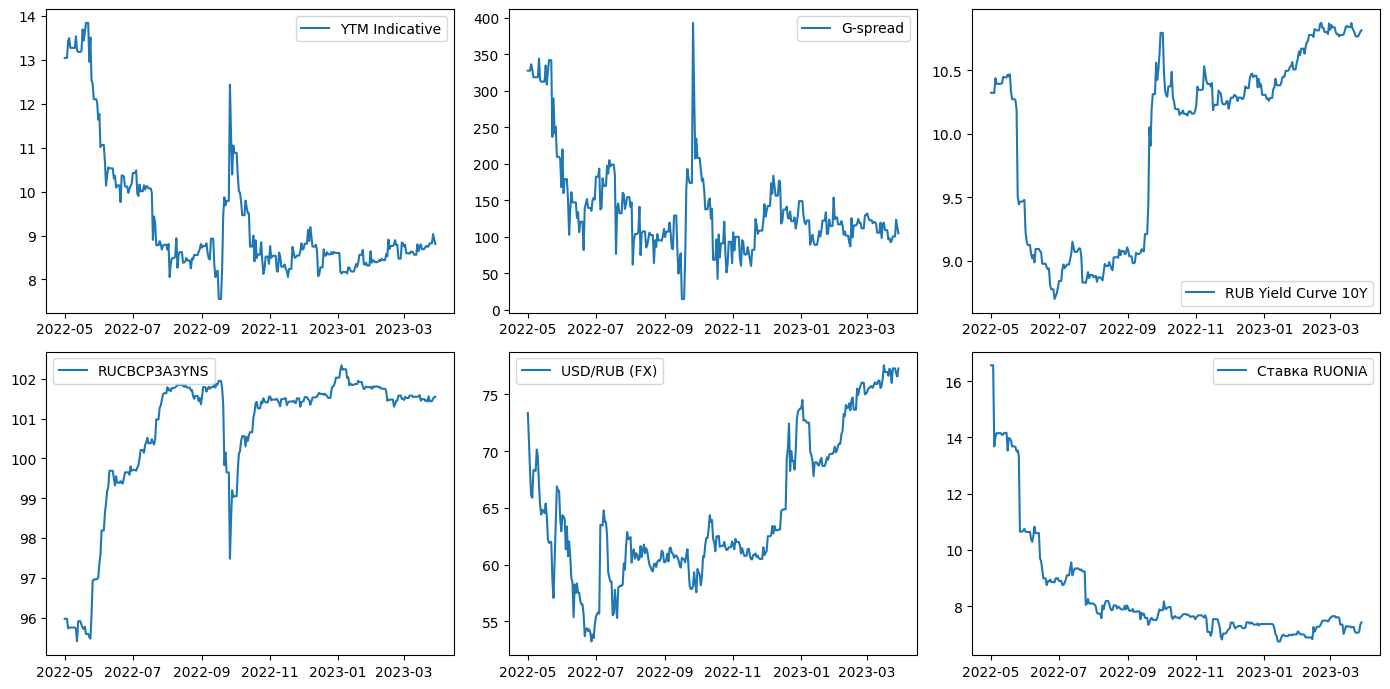

In [ ]:
fac_plots(df_alph)

In [ ]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [ ]:
outliers = {}
for name in df_alph.select_dtypes(include = numerics).columns:
  outliers['{}'.format(name)] = find_outliers_IQR(df_alph[name])

In [ ]:
def cap_outliers_by_list(data): 
  outliers = find_outliers_IQR(data)
  if len(outliers) > 0:
    if outliers[0] > data.median():
      sort_df = data.sort_values(ascending = False)
    else: 
      sort_df = data.sort_values(ascending = True)
    sort_df.iloc[0:len(outliers)] = sort_df.iloc[len(outliers)+1]
    data = sort_df.sort_index()
  return(data)

In [ ]:
for name in df_alph.select_dtypes(include = numerics).columns:
  if len(outliers[name]) > 0:
    df_alph[name] = cap_outliers_by_list(df_alph[name])

In [ ]:
for name in df_alph.select_dtypes(include = numerics).columns:
    df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name] = cap_outliers_by_list(df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name])

In [ ]:
# dfs[0] = df_alph.copy()

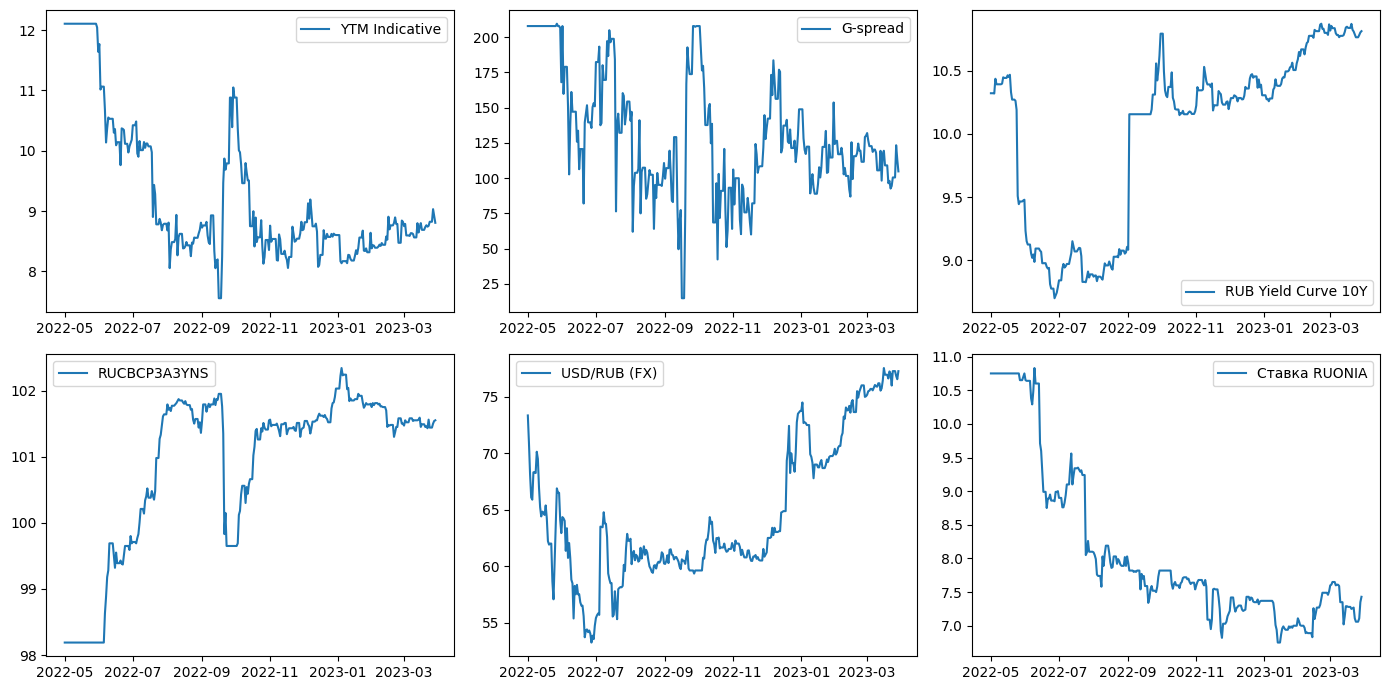

In [ ]:
fac_plots(df_alph)

In [ ]:
for name in ['YTM Indicative',  'USD/RUB (FX)', 'Ставка RUONIA']:
  df_alph[name] = np.exp(df_alph[name])

df_alph['RUCBCP3A3YNS'] = np.log(df_alph['RUCBCP3A3YNS'])

for name in ['YTM Indicative',  'USD/RUB (FX)', 'Ставка RUONIA']:
  df_alph[name] = df_alph[name]/10000

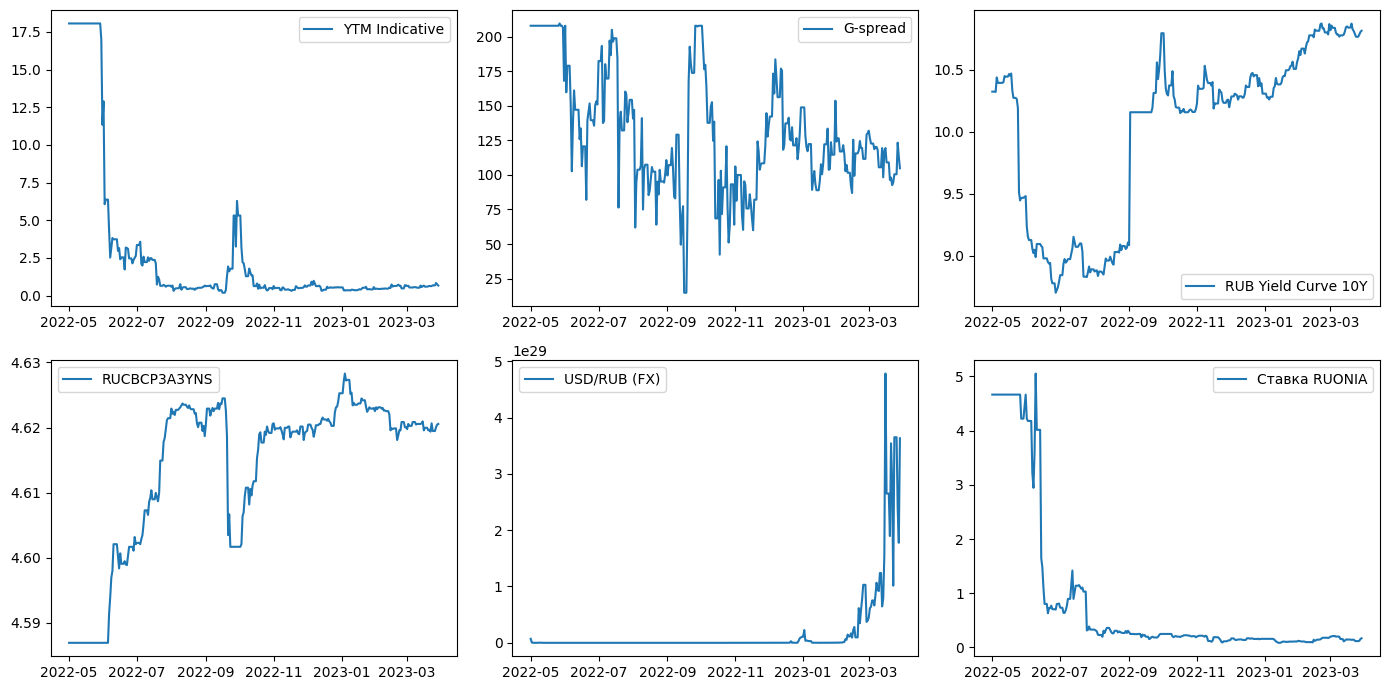

In [ ]:
fac_plots(df_alph)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 333 entries, 2022-05-01 to 2023-03-29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Indicative           333 non-null    float64
 1   YTM Indicative       333 non-null    float64
 2   G-spread             333 non-null    float64
 3   t                    333 non-null    int64  
 4   ISIN                 333 non-null    object 
 5   name                 333 non-null    object 
 6   RUB Yield Curve 10Y  333 non-null    float64
 7   RUCBCP3A3YNS         333 non-null    float64
 8   USD/RUB (FX)         333 non-null    float64
 9   Ставка RUONIA        333 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 36.7+ KB
None
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 1
Indicative             0
YTM Indicative         0
G-spread               0
t                      0
ISIN                   0
name                   

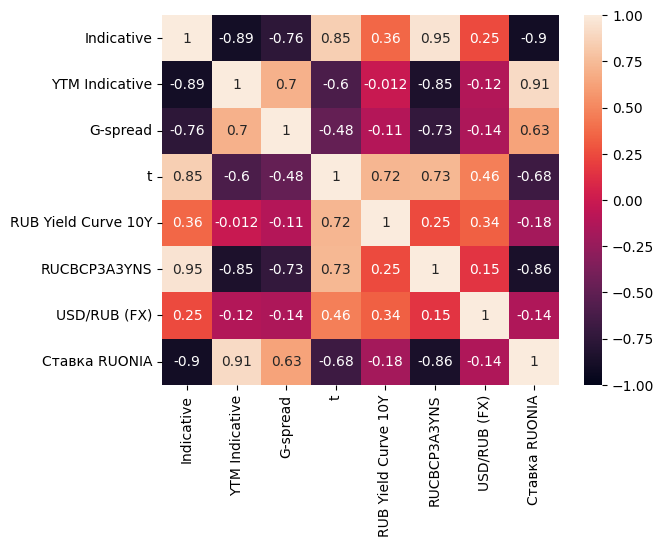

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 4
Series([], Name: Indicative, dtype: float64)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 5


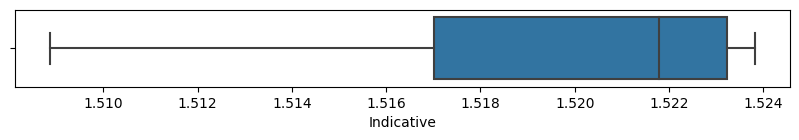

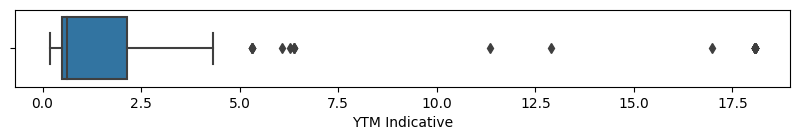

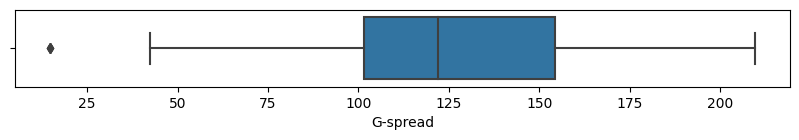

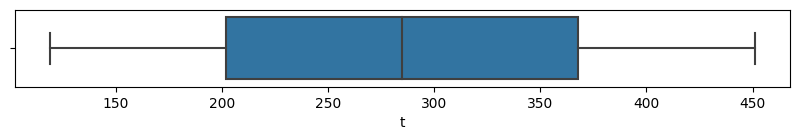

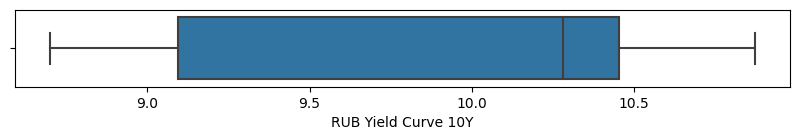

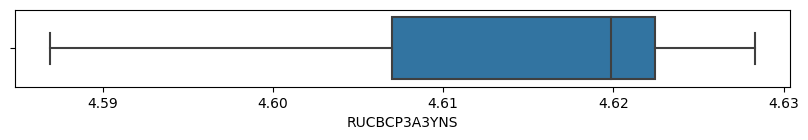

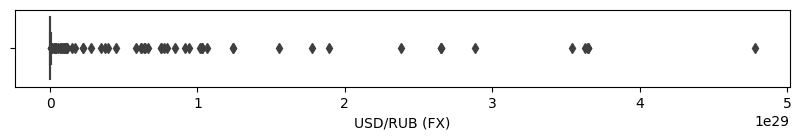

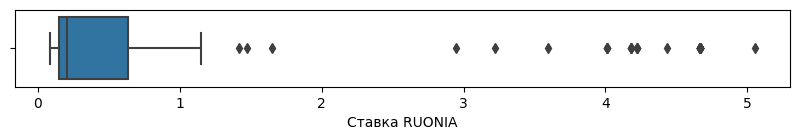

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 6


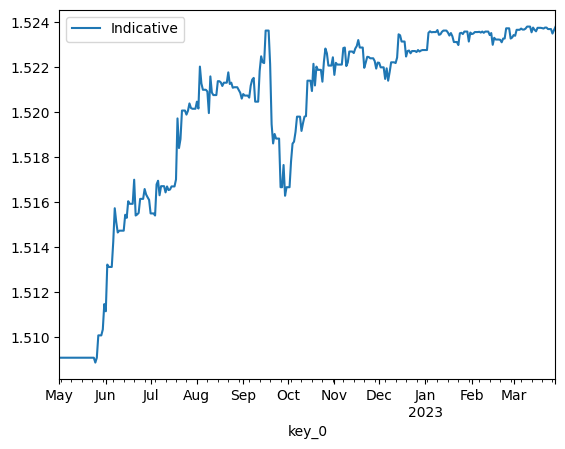

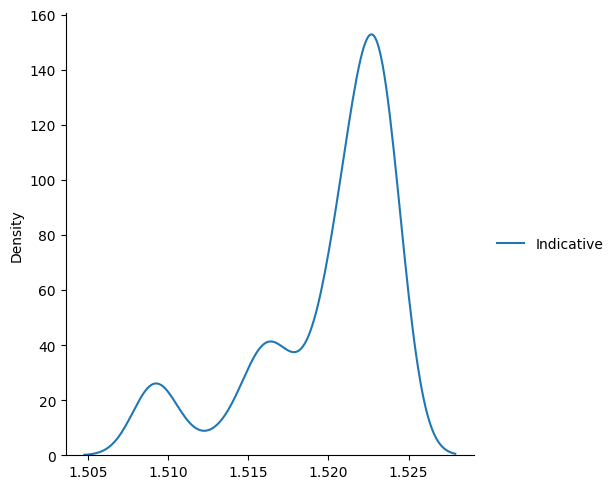

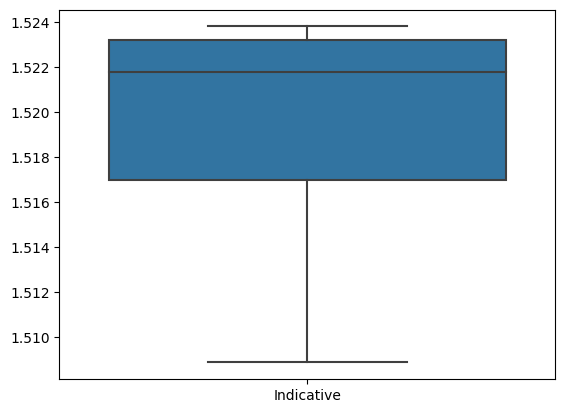

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 7
Тест Jarque Bera
        JB                p-value                 skew             kurtosis    
-------------------------------------------------------------------------------
109.39008237260857 1.7629720428093377e-24 -1.3513541138570118 3.761142651922403
-------------------------------------------------------------------------------

Тест Шапиро-Уилк
Statistics=0.790, p-value=0.000
Отклонить гипотезу о нормальности
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 8
Тест Jarque Bera
        JB                p-value                 skew             kurtosis    
-------------------------------------------------------------------------------
109.39008237260857 1.7629720428093377e-24 -1.3513541138570118 3.761142651922403
-------------------------------------------------------------------------------

Тест Шапиро-Уилк
Statistics=0.790, p-value=0.000
Отклонить гипотезу о нормальности
None


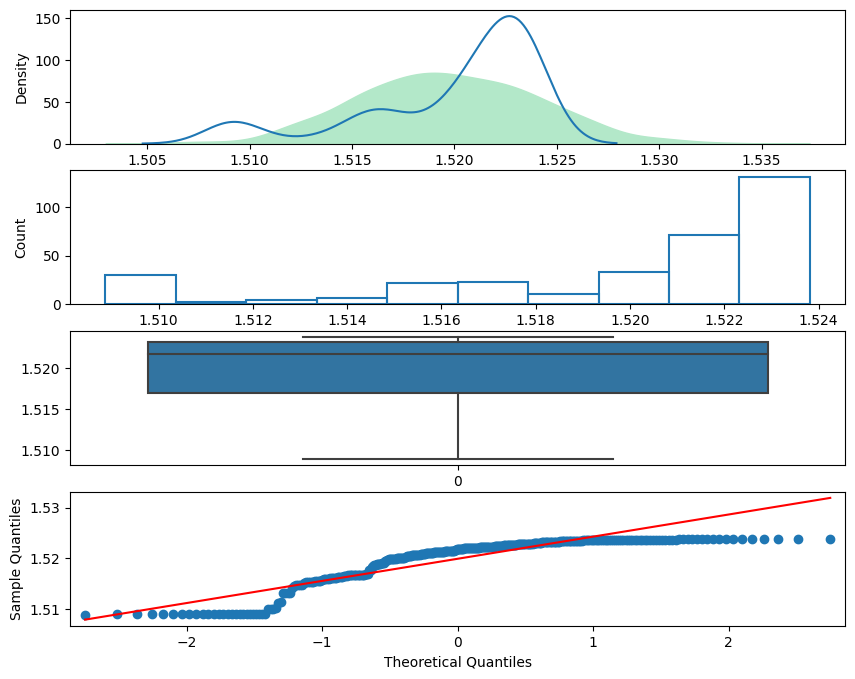

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 9


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


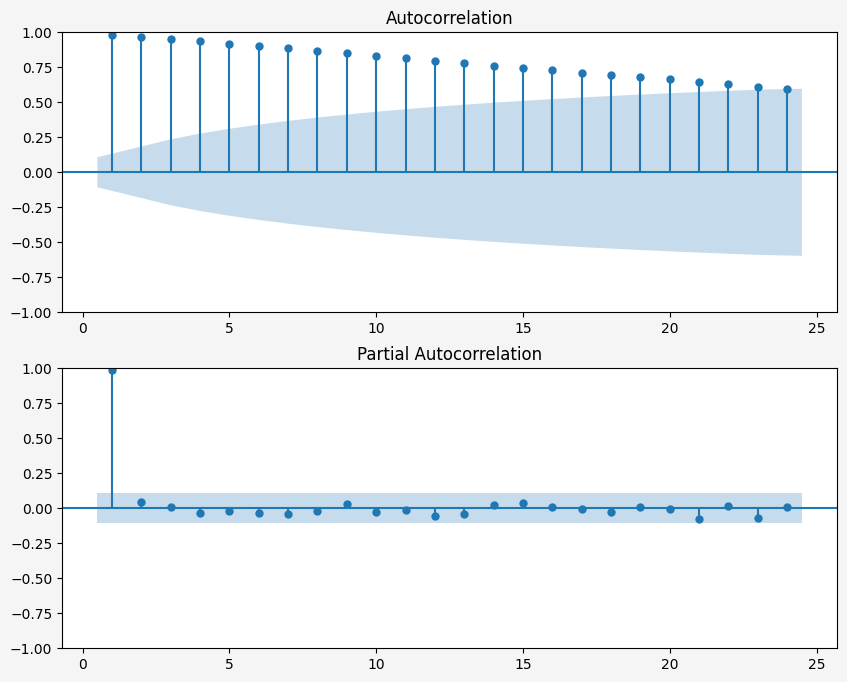

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 10
Тестирование средних. Статистика Стьюдента: -1.375598496663896. Критическое значение: 1.6541409762941324
Тестирование дисперсий. Статистика Фишера: 0.026220016276650458. Критическое значение: 1.2922643067470976
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 11
excess kurtosis of normal distribution (should be 0): 0.7611426519224032
skewness of normal distribution (should be 0): -1.3513541138570118


In [ ]:
ult_analysis(df_alph)

In [ ]:
siegel_tukey(df_alph['Indicative'])
test_mannwhitneyu(df_alph['Indicative']

z value: -1.078
Probably the same distribution
stat=646, p=646
Probably different distributions


<ipython-input-32-f5099d49252a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = dfs[0].corr(method='pearson')
<ipython-input-32-f5099d49252a>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corrmat_significance.values[[np.arange(corrmat_significance.shape[0])]*2] = 0


<Axes: >

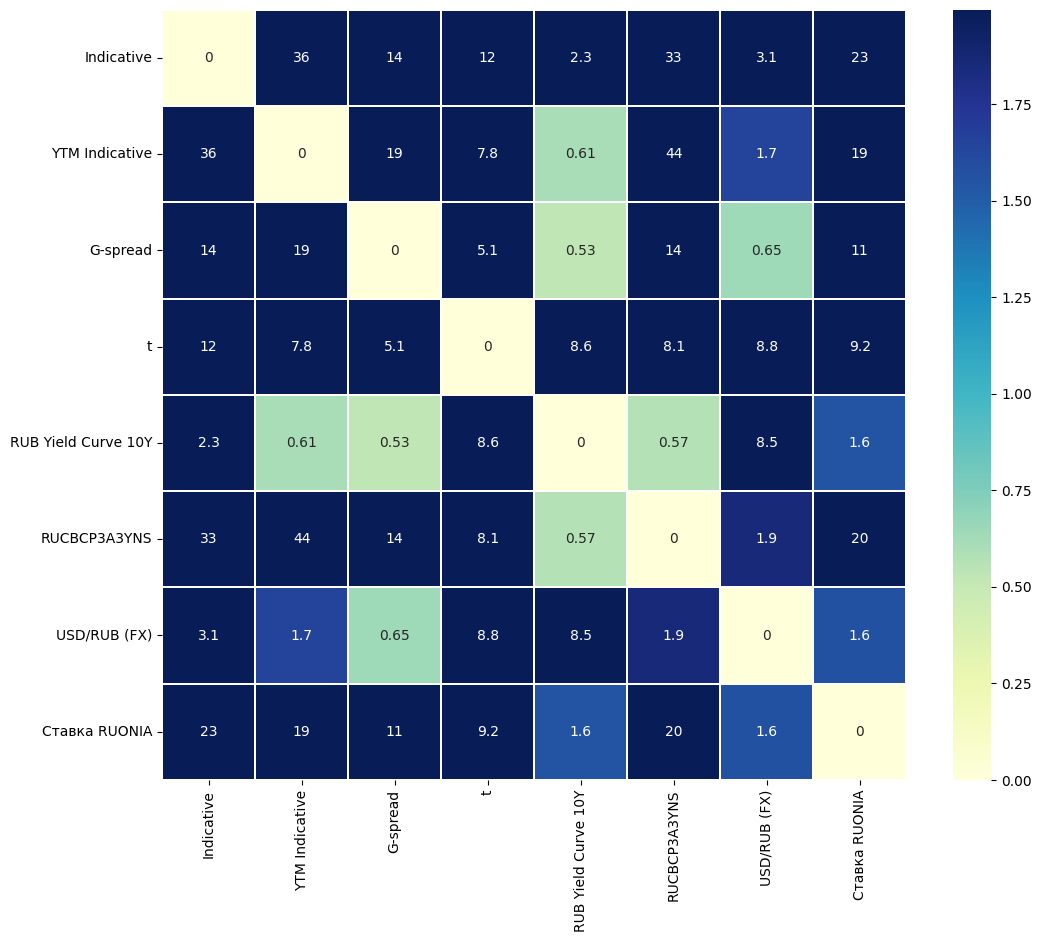

In [ ]:
corrmat = dfs[0].corr(method='pearson')

corrmat_significance = np.abs(corrmat/np.sqrt(1-np.power(corrmat,2))*np.sqrt(70))
corrmat_significance.values[[np.arange(corrmat_significance.shape[0])]*2] = 0

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat_significance, ax=ax, cmap="YlGnBu", linewidths=0.1, annot=True, vmax=1.994)

Все выделенные синим цветом коэффициенты парной корреляции значимы. Можно заметить, что целевой фактор не имеет значимой корреляции ни с одним фактором, кроме avg_sal. При этом большинство других факторов имеют значимую корреляцию друг с другом. Это говорит о том, что необходимо сокращение размерности данных, чтобы избежать мультиколлинеарность и накопление ошибки.

In [ ]:
df_alph['Indicative'] = df_alph['Indicative'].shift(1)
df_alph = df_alph[1:]

## Modeling

### Метод главных компонент 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

#для удобства создадим датафрейм без столбца даты и целевого значения

df11 = df_alph.loc[:, df_alph.columns!='Indicative'].select_dtypes(include=numerics)

#для работы методом главных компонент необходимо нормализировать данные

df1 = preprocessing.normalize(df11)
df1 = pd.DataFrame(df1, columns = df11.columns)

[0.99894405 0.99999416 0.99999885 0.99999985 0.99999998 1.
 1.        ]


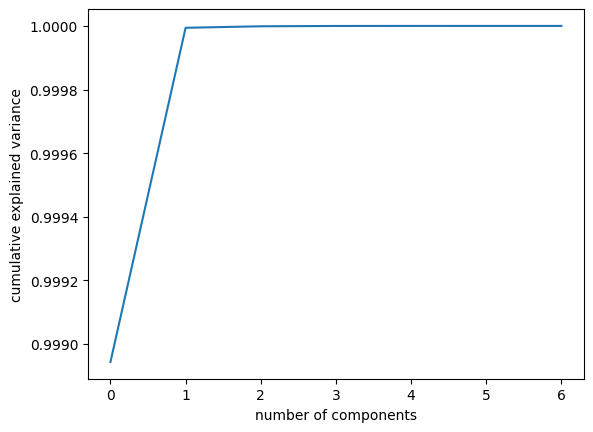

In [ ]:
pca = PCA().fit(df1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
pca_g = pca.transform(df1)

In [ ]:
df1_pca = pd.DataFrame(data = pca_g,
                      columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])

In [ ]:
df1_pca = df1_pca[['PC1', 'PC2']]

y = dfs[0]['Indicative'] - dfs[0]['Indicative'].shift(1)
y[0] = y[1]
y = y.values.reshape(1, -1)
y_n = preprocessing.normalize(y)
y_n = pd.DataFrame(y_n).T

In [ ]:
df1_pca['Ind_norm'] = y_n

<ipython-input-211-0cc071f23692>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_pca['Ind_norm'] = y_n


In [ ]:
df1_pca

,PC1,PC2,Ind_norm
0,-3.301086e-19,1.375475e-21,0.000000
1,-3.301032e-19,1.373437e-21,0.000000
2,-3.300640e-19,1.358922e-21,0.000000
3,-3.300539e-19,1.355391e-21,-0.076436
4,-3.301041e-19,1.373833e-21,-0.012259
...,...,...,...
327,-3.301090e-19,1.375611e-21,-0.005643
328,-3.301090e-19,1.375611e-21,0.000000
329,-3.301090e-19,1.375611e-21,0.000000
330,-3.301090e-19,1.375611e-21,-0.016939


In [ ]:
df_pca_cut = df1_pca[:len(df1_pca)-12]

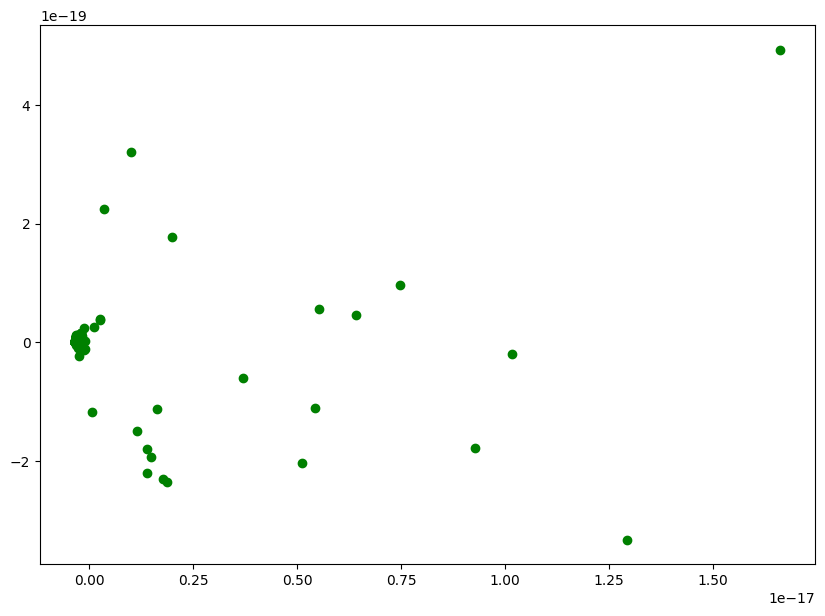

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes()
ax.scatter(df_pca_cut['PC1'], df_pca_cut['PC2'], color = "green")

In [ ]:
from scipy.stats import chi2

def calculateMahalanobis(y=None, data=None, cov=None):
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

#create new column in dataframe that contains Mahalanobis distance for each row
df_mah = df_pca_cut.copy()
df_mah['mahalanobis'] = calculateMahalanobis(y=df_mah[['PC1', 'PC2']], data=df_mah[['PC1', 'PC2']])
df_mah['p_value'] = 1 - chi2.cdf(df_mah['mahalanobis'], 2)
df_mah

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,PC1,PC2,Ind_norm,mahalanobis,p_value
0,-3.301086e-19,1.375475e-21,0.000000,0.043150,0.978656
1,-3.301032e-19,1.373437e-21,0.000000,0.043147,0.978658
2,-3.300640e-19,1.358922e-21,0.000000,0.043123,0.978669
3,-3.300539e-19,1.355391e-21,-0.076436,0.043117,0.978672
4,-3.301041e-19,1.373833e-21,-0.012259,0.043148,0.978657
...,...,...,...,...,...
315,-3.301090e-19,1.375613e-21,0.000000,0.043151,0.978656
316,-3.301090e-19,1.375613e-21,-0.021636,0.043151,0.978656
317,-3.301090e-19,1.375611e-21,0.017875,0.043151,0.978656
318,-3.301090e-19,1.375610e-21,-0.008465,0.043151,0.978656


In [ ]:
df_mah.loc[df_mah['p_value'] < 0.05]

,PC1,PC2,Ind_norm,mahalanobis,p_value
49,1.013862e-18,3.212528e-19,0.000000,35.846905,1.644158e-08
50,1.016712e-17,-1.882580e-20,0.090421,37.438958,7.417091e-09
51,5.419556e-18,-1.105955e-19,-0.134332,14.783578,6.162926e-04
52,5.126639e-18,-2.026013e-19,0.003907,23.571827,7.611020e-06
53,6.428453e-18,4.663433e-20,0.005860,15.645155,4.005878e-04
54,5.523628e-18,5.699475e-20,0.052653,12.109000,2.347275e-03
55,7.475935e-18,9.728914e-20,0.000000,23.412292,8.243002e-06
56,1.660682e-17,4.932189e-19,0.000000,183.252382,0.000000e+00
57,9.285520e-18,-1.785151e-19,0.036963,42.073557,7.308752e-10
58,1.292266e-17,-3.319603e-19,-0.020418,98.202279,0.000000e+00


In [ ]:
df1_pca['PC1'] = cap_outliers(df1_pca['PC1'], 0, 24)
df1_pca['PC2'] = cap_outliers(df1_pca['PC2'], 0, 7)

Регрессия

In [ ]:
df_pca = df1_pca[['PC1', 'PC2']]

import statsmodels.api as sm
X = sm.add_constant(df_pca[:len(df_pca)-12])
est1 = sm.OLS(y_n[:len(y_n)-13], X)
est12 = est1.fit()
print(est12.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 16 May 2023   Prob (F-statistic):                nan
Time:                        10:57:27   Log-Likelihood:                 470.04
No. Observations:                 320   AIC:                            -938.1
Df Residuals:                     319   BIC:                            -934.3
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.441      0.1

In [ ]:
Ind_pred = est12.predict(sm.add_constant(df_pca))
Ind_prediction = Ind_pred * np.sqrt(np.power(dfs[0]['Indicative']- dfs[0]['Indicative'].shift(1),2).sum())

In [ ]:
dfs[0]['Indicative']- dfs[0]['Indicative'].shift(1)

key_0
2022-05-01      NaN
2022-05-02    0.000
2022-05-03    0.000
2022-05-04   -0.375
2022-05-05   -0.060
              ...  
2023-03-25    0.000
2023-03-26    0.000
2023-03-27   -0.090
2023-03-28    0.070
2023-03-29    0.065
Name: Indicative, Length: 333, dtype: float64

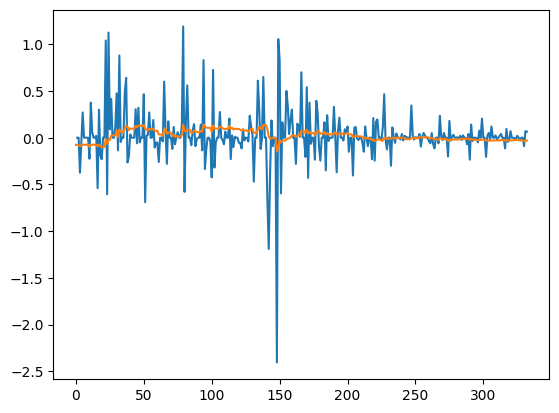

In [ ]:
plt.plot(range(len(y_n)), dfs[0]['Indicative']- dfs[0]['Indicative'].shift(1), range(len(Ind_pred)), Ind_prediction.values)
plt.show()

### Feature selection

In [ ]:
df_alph = df_alph.dropna()

In [ ]:
X = df_alph.drop('Indicative', axis = 1).select_dtypes(include=numerics)
Y = df_alph['Indicative']

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
test = SelectKBest(score_func=f_classif, k=4)

In [ ]:
fit = test.fit(X, Y)

In [ ]:
X.columns

Index(['YTM Indicative', 'G-spread', 't', 'RUB Yield Curve 10Y',
       'RUCBCP3A3YNS', 'USD/RUB (FX)', 'Ставка RUONIA'],
      dtype='object')

In [ ]:
from numpy import set_printoptions
set_printoptions(precision=3)
print(fit.scores_)

[163.07    4.767  53.334  22.462  70.404   4.039  98.401]


Наивысшие результаты у YTM Indicative, G-spread, RUB Yield Curve 10Y, RUCBCP3A3YNS. Используем их в моделировании

In [ ]:
dfs[0][dfs[0]['G-spread'] == np.max(dfs[0]['G-spread'])]['G-spread'] = dfs[0]['G-spread'].median()

<ipython-input-170-fda1cd2114b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs[0][dfs[0]['G-spread'] == np.max(dfs[0]['G-spread'])]['G-spread'] = dfs[0]['G-spread'].median()


In [ ]:
dfs[0].select_dtypes(include=numerics)[dfs[0]['G-spread'] == np.max(dfs[0]['G-spread'])]

,Indicative,YTM Indicative,G-spread,t,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,
2022-09-26,-2.405,12.4332,393.032344,267,10.5585,97.48,58.13614,7.5


In [ ]:
for name in ['YTM Indicative', 'G-spread', 'RUB Yield Curve 10Y', 'RUCBCP3A3YNS']:
  dfs[0][name].plot()
  plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[['YTM Indicative', 'G-spread', 'RUB Yield Curve 10Y', 'RUCBCP3A3YNS']], Y, test_size=0.33, random_state=42)

In [ ]:
features = fit.transform(X)

### Общие линейные модели

In [ ]:
alph_feat[1:]['Indicative']

key_0
2022-05-05    1.509088
2022-05-06    1.509088
2022-05-07    1.509088
2022-05-08    1.509088
2022-05-09    1.509088
                ...   
2023-03-25    1.523771
2023-03-26    1.523771
2023-03-27    1.523704
2023-03-28    1.523704
2023-03-29    1.523704
Name: Indicative, Length: 329, dtype: float64

In [ ]:
#Тривиальная модель

alph_feat = df_alph[['Indicative', 'YTM Indicative', 't', 'RUCBCP3A3YNS', 'Ставка RUONIA']]
print(np.sqrt(np.var(alph_feat[1:]['Indicative'] - alph_feat['Indicative'].shift(1))))

0.0005042175942607969


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)

r_sq = model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

y_pred = model.predict(X_train)

coefficient of determination: 0.1373550257875189
intercept: 32.33432445871296
coefficients: [-0.346  0.    -0.018 -0.288]


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train)
model = LinearRegression().fit(x_, y_train)

r_sq = model.score(x_, y_train)
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")


coefficient of determination: 0.2620722543101702
intercept: -3775.7920416003963
coefficients: [ 9.927e+01 -2.588e-01  1.660e+01  6.479e+01 -5.307e-01 -2.881e-03
 -1.499e-01 -8.715e-01  7.193e-05  2.071e-04  2.614e-03  7.797e-02
 -1.661e-01 -2.762e-01]


In [ ]:
import statsmodels.api as sm

X_lm = sm.add_constant(X_train)
regr = sm.OLS(y_train, X_lm)
regr2 = regr.fit()
print(regr2.summary())

                            OLS Regression Results                            
Dep. Variable:             Indicative   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     8.638
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.73e-06
Time:                        23:30:42   Log-Likelihood:                 17.415
No. Observations:                 222   AIC:                            -24.83
Df Residuals:                     217   BIC:                            -7.816
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  32.3343    

In [ ]:
regr2 = regr.fit()
print(regr2.summary())

### Решающие деревья

### LS-boosting

### Random forest

In [ ]:

# forecast monthly births with random forest
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [ ]:
def train_test_split(X, y, n_test):
 return X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]

In [ ]:
X = alph_feat.drop('Indicative', axis = 1)
y = alph_feat['Indicative'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, 130)

model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train, y_train)
#y_pred = model.predict([X_test])

RandomForestRegressor(n_estimators=1000)

In [ ]:
X_test

,YTM Indicative,t,RUCBCP3A3YNS,Ставка RUONIA
key_0,,,,
2022-11-20,0.379030,322,4.619369,0.188183
2022-11-21,0.625853,323,4.619369,0.166903
2022-11-22,0.556026,324,4.619566,0.140810
2022-11-23,0.487902,325,4.619073,0.101232
2022-11-24,0.494385,326,4.618974,0.091599
...,...,...,...,...
2023-03-25,0.679064,447,4.619467,0.116445
2023-03-26,0.679064,448,4.619467,0.116445
2023-03-27,0.836741,449,4.620059,0.122415


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
print('MSE = %.4g' % mean_squared_error(y_test,predictions))

MSE = 5.347e-07


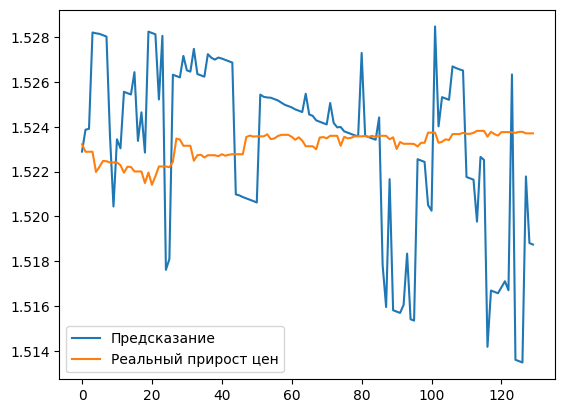

In [ ]:
plt.plot(range(len(predictions)), predictions, label = 'Предсказание')
plt.plot(range(len(predictions)), y_test, label = 'Реальный прирост цен')
plt.legend()
plt.show()

In [ ]:
!pip install -q --upgrade linear-tree

from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 30, 
                                 max_depth    = 5,
                                 random_state = 42)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

MSE = 1.775e-06


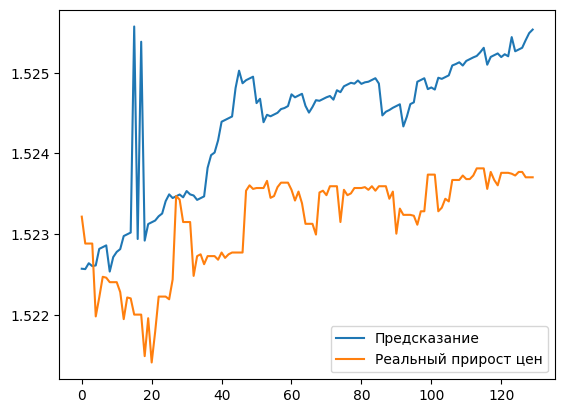

In [ ]:
print('MSE = %.4g' % mean_squared_error(y_test,predictions))

plt.plot(range(len(predictions)), predictions, label = 'Предсказание')
plt.plot(range(len(predictions)), y_test, label = 'Реальный прирост цен')
plt.legend()
plt.show()

In [ ]:
mae, y, yhat = walk_forward_validation(alph_feat[], 12)
print('MAE: %.3f' % mae)

KeyError: ignored

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
  # split test row into input and output columns
  testX, testy = test[i, :-1], test[i, -1]
  # fit model on history and make a prediction
  yhat = random_forest_forecast(history, testX)
  # store forecast in list of predictions
  predictions.append(yhat)
  # add actual observation to history for the next loop
  history.append(test[i])
 # summarize progress
 print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 return error, test[:, 1], predictions

## working with a merged dataset

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# df = pd.read_excel('dataset_vkr.xlsx')

In [ ]:
df.head(5)

,Дата,Indicative,YTM Indicative,G-spread,t,ISIN_RU000A0JV4L2,ISIN_RU000A0JV4M0,ISIN_RU000A0ZYLQ4,ISIN_RU000A101C89,ISIN_RU000A101KT1,ISIN_RU000A101QM3,ISIN_RU000A102A07,ISIN_RU000A102EJ3,ISIN_RU000A102KZ6
0,2022-01-03,96.550,8.1217,-6.763896,1,0,0,0,0,0,0,1,0,0
1,2022-01-03,101.120,12.9511,469.994254,1,1,0,0,0,0,0,0,0,0
2,2022-01-03,95.550,9.6897,148.998138,1,0,0,0,0,0,0,0,0,1
3,2022-01-03,98.540,NaN,NaN,1,0,0,0,0,1,0,0,0,0
4,2022-01-03,95.985,8.6476,44.336702,1,0,0,0,1,0,0,0,0,0


<Axes: >

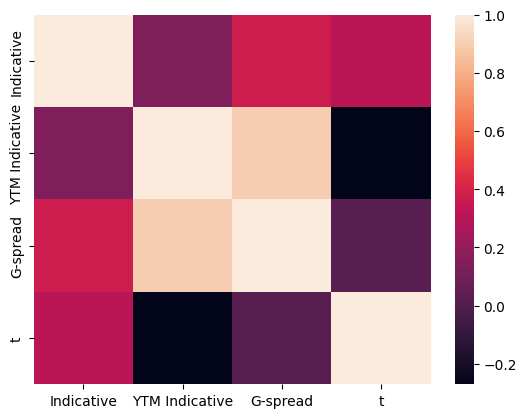

In [ ]:
sns.heatmap(df[['Indicative', 'YTM Indicative', 'G-spread', 't']].corr())

In [ ]:
for i in range(len(dfs)):
  dfs[i]['Indicative'].plot()
  print(dfs[i]['name'][1])
  plt.show()

In [ ]:
df_ind = {}
df_ind['bank'] = merge_dfs(dfs[0:2])
df_ind['oil'] = merge_dfs(dfs[3:5])
df_ind['ofz'] = merge_dfs(dfs[6:8])

In [ ]:
df_ind['bank']

,Indicative,YTM Indicative,G-spread,t,ISIN_RU000A102A07,ISIN_RU000A102EJ3,name_альфа-банк.xlsx,name_банк-втб.xlsx
Дата,,,,,,,,
2022-01-03,96.550,8.1217,-6.763896,1,1,0,1,0
2022-01-04,96.235,8.3266,13.549479,2,1,0,1,0
2022-01-05,95.690,8.6823,50.324341,3,1,0,1,0
2022-01-05,99.145,0.2288,-804.340413,1,0,1,0,1
2022-01-06,95.505,8.8061,36.877612,4,1,0,1,0
...,...,...,...,...,...,...,...,...
2023-03-27,98.325,9.0321,123.315343,449,1,0,1,0
2023-03-28,98.395,8.9138,113.175647,450,1,0,1,0
2023-03-28,93.620,2.4785,-612.861891,448,0,1,0,1
